In [ ]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
import natsort
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! mkdir data
! cd data

preprocessed data is uploaded to kaggle and brought to colab env 

In [ ]:
!kaggle datasets download -d bsashank/apple-disease-classification

100% 398M/399M [00:11<00:00, 55.2MB/s]
100% 399M/399M [00:11<00:00, 37.5MB/s]


In [ ]:
!unzip /content/apple-disease-classification.zip

In [ ]:
train=pd.read_csv(r"train.csv")
test=pd.read_csv(r"test.csv")

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


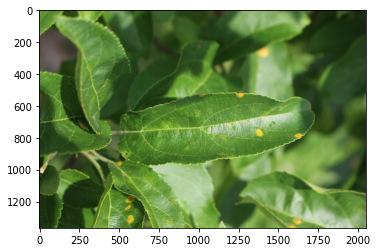

In [ ]:
image1=Image.open(r'test\Test_0.jpg')
plt.imshow(image1)
plt.show()

# Data Preprocessing

In [ ]:
IMG_SIZE=224
#new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
#plt.imshow(new_image)
#plt.show()

# Model Prepration

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D


In [ ]:
datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)


train_datagen=datagen.flow_from_directory(r'/content/train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='training')

val_datagen=datagen.flow_from_directory(r'/content/train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='validation')

Found 1530 images belonging to 4 classes.
Found 381 images belonging to 4 classes.


In [ ]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(4,activation='softmax'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)           

In [ ]:
checkpoint=ModelCheckpoint(r'\apple2.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
model_history=model.fit_generator(train_datagen,validation_data=val_datagen,
                                 epochs=30,
                                 steps_per_epoch=train_datagen.samples//16,
                                 validation_steps=val_datagen.samples//16,
                                 callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
95/95 [==============================] - 96s 1s/step - loss: 1.4499 - accuracy: 0.3234 - val_loss: 1.3395 - val_accuracy: 0.3207

Epoch 00001: val_loss improved from inf to 1.33947, saving model to \apple2.h5
Epoch 2/30
95/95 [==============================] - 94s 987ms/step - loss: 1.3066 - accuracy: 0.3054 - val_loss: 1.2907 - val_accuracy: 0.3315

Epoch 00002: val_loss improved from 1.33947 to 1.29075, saving model to \apple2.h5
Epoch 3/30
95/95 [==============================] - 94s 991ms/step - loss: 1.2353 - accuracy: 0.4043 - val_loss: 1.1564 - val_accuracy: 0.4592

Epoch 00003: val_loss improved from 1.29075 to 1.15638, saving model to \apple2.h5
Epoch 4/30
95/95 [==============================] - 94s 991ms/step - loss: 1.0949 - accuracy: 0.5027 - val_loss: 1.0557 - val_accuracy: 0.5462

Epoch 00004: val_loss improved from 1.15638 to 1.05574, saving model to \apple2.h5
Epoch 5/30
95/95 [==============================] - 93s 982ms/step - loss: 0.9857 - accuracy: 0.605

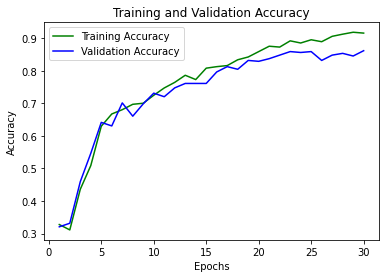

In [ ]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,31)
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

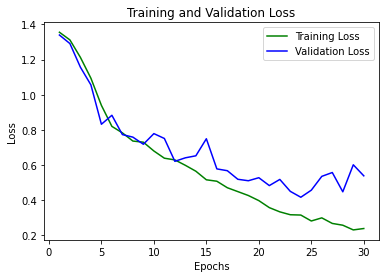

In [ ]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,31)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Making the Prediction on a Single Image

2


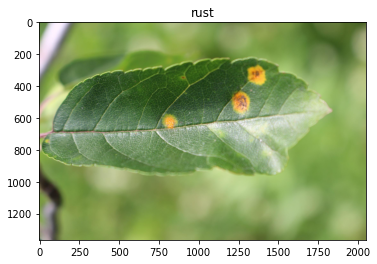

In [ ]:
test_image=r'train\Train_3.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
print(np.argmax(result))
Categories=['healthy','multiple_disease','rust','scab']
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()